In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from modules import data_loader, metrics, learning, plotting, utils, params, pipelines
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from modules.gmp_model import GMP
from modules.nn_model import GRU, LSTM

Load data from files and init acpr meter

In [3]:
data = data_loader.load_data("DPA_200MHz")

config = data["config"]
fs = config["input_signal_fs"]
bw_main_ch = config["bw_main_ch"]
bw_sub_ch = config["bw_sub_ch"]
n_sub_ch = config["n_sub_ch"]
sub_ch = config["sub_ch"]
nperseg = config["nperseg"]

x_train = data["train_input"]
y_train = data["train_output"]
x_val = data["val_input"]
y_val = data["val_output"]

gain = metrics.calculate_gain_complex(x_train, y_train)
print(f"PA gain = {gain:.2f}")
y_train_target = gain * x_train
y_val_target = gain * x_val

data['y_train_target'] = y_train_target
data['y_val_target'] = y_val_target

acpr_meter = metrics.ACPR(
        sample_rate=fs,
        main_measurement_bandwidth=bw_main_ch,
        adjacent_channel_offset=[-sub_ch, sub_ch],
        segment_length=nperseg,
        overlap_percentage=60,
        window='blackmanharris',
        fft_length=nperseg,
        power_units='dBW',
        return_main_power=True,
        return_adjacent_powers=True
    )


PA gain = 2.52


In [112]:
frame_length = 16
batch_size = 256
batch_size_eval = 2048

pa_train_loader, pa_val_loader = data_loader.build_dataloaders(data_dict=data, frame_length=frame_length, batch_size=batch_size, batch_size_eval=batch_size_eval)
dla_train_loader, dla_val_loader = data_loader.build_dataloaders(data_dict=data, frame_length=frame_length, batch_size=batch_size, batch_size_eval=batch_size_eval, arch="dla")
ila_train_loader, ila_val_loader = data_loader.build_dataloaders(data_dict=data, frame_length=frame_length, batch_size=batch_size, batch_size_eval=batch_size_eval, arch="ila")

criterion_gru = metrics.compute_mse
metric_criterion = metrics.compute_nmse

PA

In [35]:
epochs = 20
lr = 0.01
gru_pa = GRU(hidden_size=64, num_layers=1, model_name="pa")

optimizer_gru = torch.optim.Adam(gru_pa.parameters(), lr=lr)

if not gru_pa.load_weights():
      learning.train(net=gru_pa, 
            criterion=criterion_gru, 
            optimizer=optimizer_gru, 
            train_loader=pa_train_loader, 
            val_loader=pa_val_loader, 
            grad_clip_val=1.0, 
            n_epochs=epochs, 
            metric_criterion=metric_criterion)
      gru_pa.save_weights()
utils.freeze_pa_model(gru_pa)

y_val_gru_pa = learning.net_inference(net=gru_pa, x=x_val)
gru_pa_nmse = metrics.compute_nmse(y_val_gru_pa, y_val)
print(f"Model NMSE: {gru_pa_nmse:.2f}")


Model weights loaded from model_params/pa_gru_model_hs64_nl1_in2_out2.pt
Model NMSE: -35.69


c:\Users\maximp\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:652: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


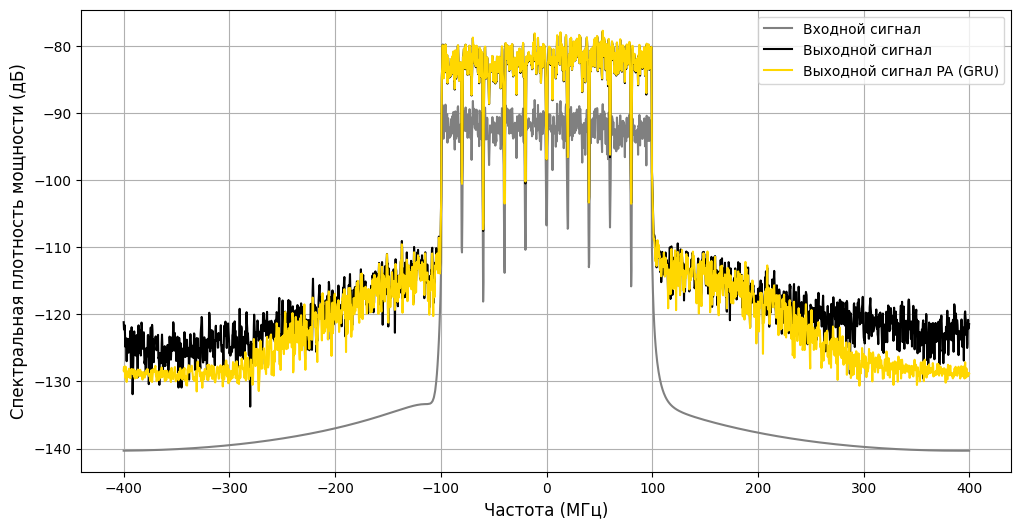

In [36]:
freqs, spectrum_x_val = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_val = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_gru_pa = metrics.power_spectrum(y_val_gru_pa, fs, nperseg)

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_x_val)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val)), color='black', label='Выходной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_gru_pa)), color='gold', label='Выходной сигнал PA (GRU)')


plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


DLA DPD

In [113]:
epochs = 20
lr = 0.01
gru_dla = GRU(hidden_size=128, num_layers=1, model_name="dla")
is_load = gru_dla.load_weights()
casc_gru_dla = utils.CascadeModel(model_1=gru_dla, model_2=gru_pa, cascade_type="dla")

optimizer_gru = torch.optim.Adam(casc_gru_dla.parameters(), lr=lr)

if not is_load:
    learning.train(net=casc_gru_dla, 
                   criterion=criterion_gru, 
                   optimizer=optimizer_gru, 
                   train_loader=dla_train_loader, 
                   val_loader=dla_val_loader, 
                   grad_clip_val=1.0, 
                   n_epochs=epochs, 
                   metric_criterion=metric_criterion)
    gru_dla.save_weights()

y_val_gru_dla = learning.net_inference(net=casc_gru_dla, x=x_val)
gru_dla_nmse = metrics.compute_nmse(y_val_gru_dla, y_val_target)
print(f"Model NMSE: {gru_dla_nmse:.2f}")


No saved weights found at model_params/dla_gru_model_hs128_nl1_in2_out2.pt, initializing new parameters.
===Start training===
Epoch 00 — train_loss: 0.027446, val_loss: 0.000571, val_NMSE: -31.35
Epoch 01 — train_loss: 0.000499, val_loss: 0.000520, val_NMSE: -31.76
Epoch 02 — train_loss: 0.000414, val_loss: 0.000509, val_NMSE: -31.85
Epoch 03 — train_loss: 0.000347, val_loss: 0.000498, val_NMSE: -31.94
Epoch 04 — train_loss: 0.000300, val_loss: 0.000472, val_NMSE: -32.18
Epoch 05 — train_loss: 0.000248, val_loss: 0.000417, val_NMSE: -32.72
Epoch 06 — train_loss: 0.000225, val_loss: 0.000394, val_NMSE: -32.96
Epoch 07 — train_loss: 0.000171, val_loss: 0.000340, val_NMSE: -33.60
Epoch 08 — train_loss: 0.000145, val_loss: 0.000355, val_NMSE: -33.42
Epoch 09 — train_loss: 0.000170, val_loss: 0.000327, val_NMSE: -33.77
Epoch 10 — train_loss: 0.000110, val_loss: 0.000324, val_NMSE: -33.81
Epoch 11 — train_loss: 0.000115, val_loss: 0.000382, val_NMSE: -33.09
Epoch 12 — train_loss: 0.000124, v

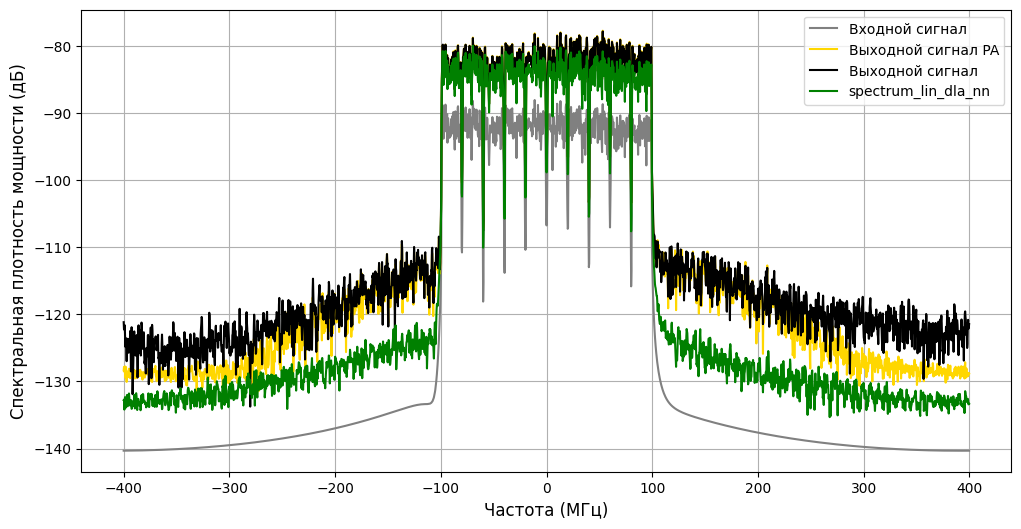

In [114]:
freqs, spectrum_x_val = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_val = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_y_val_gru_pa = metrics.power_spectrum(y_val_gru_pa, fs, nperseg)
_, spectrum_lin_dla_nn = metrics.power_spectrum(y_val_gru_dla, fs, nperseg)

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_x_val)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_pa)), color='gold', label='Выходной сигнал PA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val)), color='black', label='Выходной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_lin_dla_nn)), color='green', label='spectrum_lin_dla_nn')


plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


ILA DPD grad

In [116]:
epochs = 20
lr = 0.01
gru_ila = GRU(hidden_size=128, num_layers=1, model_name="ila")
is_load = gru_ila.load_weights()
casc_gru_ila_train = utils.CascadeModel(model_2=gru_ila, model_1=gru_pa, gain=gain, cascade_type="ila")
casc_gru_ila_eval = utils.CascadeModel(model_1=gru_ila, model_2=gru_pa, cascade_type="dla")

optimizer_gru = torch.optim.Adam(casc_gru_ila_train.parameters(), lr=lr)

if not is_load:
    learning.train(net=casc_gru_ila_train, 
                   criterion=criterion_gru, 
                   optimizer=optimizer_gru, 
                   train_loader=ila_train_loader, 
                   val_loader=ila_val_loader, 
                   grad_clip_val=1.0, 
                   n_epochs=epochs, 
                   metric_criterion=metric_criterion)
    gru_ila.save_weights()

y_val_gru_ila = learning.net_inference(net=casc_gru_ila_eval, x=x_val)
gru_ila_nmse = metrics.compute_nmse(y_val_gru_ila, y_val_target)
print(f"Model NMSE: {gru_ila_nmse:.2f}")


No saved weights found at model_params/ila_gru_model_hs128_nl1_in2_out2.pt, initializing new parameters.
===Start training===
Epoch 00 — train_loss: 0.003479, val_loss: 0.000172, val_NMSE: -28.53
Epoch 01 — train_loss: 0.000155, val_loss: 0.000161, val_NMSE: -28.82
Epoch 02 — train_loss: 0.000130, val_loss: 0.000130, val_NMSE: -29.75
Epoch 03 — train_loss: 0.000097, val_loss: 0.000107, val_NMSE: -30.62
Epoch 04 — train_loss: 0.000075, val_loss: 0.000093, val_NMSE: -31.21
Epoch 05 — train_loss: 0.000063, val_loss: 0.000076, val_NMSE: -32.09
Epoch 06 — train_loss: 0.000055, val_loss: 0.000074, val_NMSE: -32.21
Epoch 07 — train_loss: 0.000048, val_loss: 0.000065, val_NMSE: -32.76
Epoch 08 — train_loss: 0.000042, val_loss: 0.000071, val_NMSE: -32.38
Epoch 09 — train_loss: 0.000042, val_loss: 0.000070, val_NMSE: -32.45
Epoch 10 — train_loss: 0.000038, val_loss: 0.000077, val_NMSE: -32.03
Epoch 11 — train_loss: 0.000035, val_loss: 0.000069, val_NMSE: -32.48
Epoch 12 — train_loss: 0.000036, v

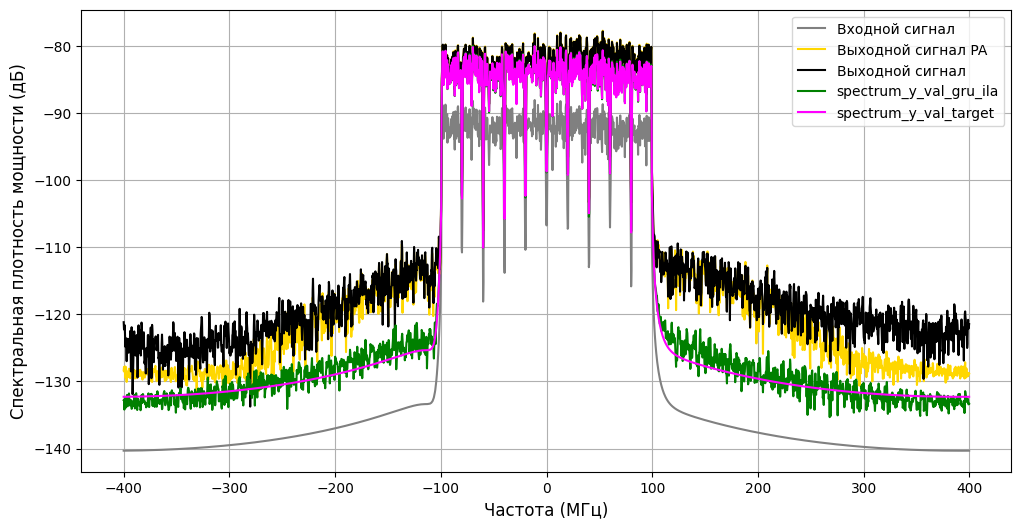

In [117]:
freqs, spectrum_x_val = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_val = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_y_val_gru_pa = metrics.power_spectrum(y_val_gru_pa, fs, nperseg)
_, spectrum_y_val_gru_ila = metrics.power_spectrum(y_val_gru_ila, fs, nperseg)
_, spectrum_y_val_target = metrics.power_spectrum(y_val_target, fs, nperseg)

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_x_val)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_pa)), color='gold', label='Выходной сигнал PA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val)), color='black', label='Выходной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_lin_dla_nn)), color='green', label='spectrum_y_val_gru_ila')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_target)), color='magenta', label='spectrum_y_val_target')


plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


ILC DPD

In [119]:
u_k_train = learning.ilc_signal(x_train, y_train_target, gru_pa, epochs=200, learning_rate=0.01)
# u_k_val = learning.ilc_signal(x_val, y_val_target, gru_pa, epochs=200, learning_rate=0.1)
u_k_pa = gru_pa.forward(u_k_train).detach()

data["ilc_train_output"] = u_k_train
# data["ilc_val_output"] = u_k_val

ilc_train_loader, ilc_val_loader = data_loader.build_dataloaders(data_dict=data, 
                                                                 frame_length=frame_length, 
                                                                 batch_size=batch_size, 
                                                                 batch_size_eval=batch_size_eval, 
                                                                 arch="ilc")

Epoch [0/200], Loss: 0.03329100459814072
Epoch [100/200], Loss: 3.7539911090789246e-07


In [121]:
epochs = 20
lr = 0.01
gru_ilc = GRU(hidden_size=128, num_layers=1, model_name="ilc")
is_load = gru_ilc.load_weights()

optimizer_gru = torch.optim.Adam(gru_ilc.parameters(), lr=lr)

if not is_load:
    learning.train(net=gru_ilc, 
                   criterion=criterion_gru, 
                   optimizer=optimizer_gru, 
                   train_loader=ilc_train_loader, 
                   val_loader=ilc_val_loader, 
                   grad_clip_val=1.0, 
                   n_epochs=epochs, 
                   metric_criterion=metric_criterion)
    gru_ilc.save_weights()

casc_gru_ilc_eval = utils.CascadeModel(model_1=gru_ilc, model_2=gru_pa, cascade_type="dla")
y_val_gru_ilc = learning.net_inference(net=casc_gru_ilc_eval, x=x_val)
gru_ilc_nmse = metrics.compute_nmse(y_val_gru_ilc, y_val_target)
print(f"Model NMSE: {gru_ilc_nmse:.2f}")


No saved weights found at model_params/ilc_gru_model_hs128_nl1_in2_out2.pt, initializing new parameters.
===Start training===
Epoch 00 — train_loss: 0.002594, val_loss: 0.078300, val_NMSE: 0.14
Epoch 01 — train_loss: 0.000110, val_loss: 0.078357, val_NMSE: 0.15
Epoch 02 — train_loss: 0.000101, val_loss: 0.078146, val_NMSE: 0.14
Epoch 03 — train_loss: 0.000093, val_loss: 0.077984, val_NMSE: 0.13
Epoch 04 — train_loss: 0.000085, val_loss: 0.078078, val_NMSE: 0.13
Epoch 05 — train_loss: 0.000077, val_loss: 0.078346, val_NMSE: 0.15
Epoch 06 — train_loss: 0.000072, val_loss: 0.078037, val_NMSE: 0.13
Epoch 07 — train_loss: 0.000071, val_loss: 0.078079, val_NMSE: 0.13
Epoch 08 — train_loss: 0.000066, val_loss: 0.078081, val_NMSE: 0.13
Epoch 09 — train_loss: 0.000064, val_loss: 0.078654, val_NMSE: 0.16
Epoch 10 — train_loss: 0.000063, val_loss: 0.077773, val_NMSE: 0.11
Epoch 11 — train_loss: 0.000061, val_loss: 0.077692, val_NMSE: 0.11
Epoch 12 — train_loss: 0.000060, val_loss: 0.078173, val_N

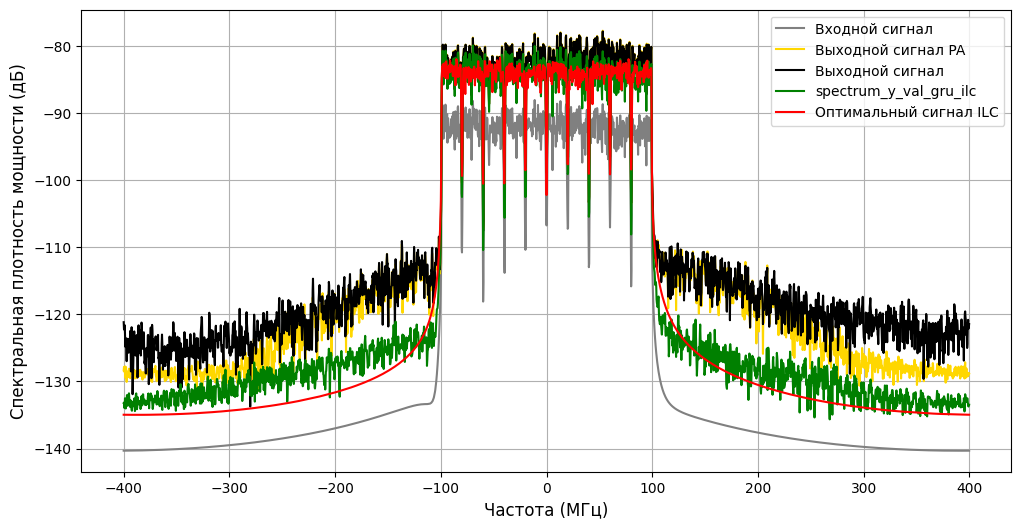

In [122]:
freqs, spectrum_x_val = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_val = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_y_val_gru_pa = metrics.power_spectrum(y_val_gru_pa, fs, nperseg)
_, spectrum_y_val_gru_ilc = metrics.power_spectrum(y_val_gru_ilc, fs, nperseg)
_, spectrum_y_val_target = metrics.power_spectrum(y_val_target, fs, nperseg)
_, spectrum_u_k_pa = metrics.power_spectrum(u_k_pa, fs, nperseg)
# _, spectrum_u_k = metrics.power_spectrum(u_k_train, fs, nperseg)


xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_x_val)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_pa)), color='gold', label='Выходной сигнал PA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val)), color='black', label='Выходной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_ilc)), color='green', label='spectrum_y_val_gru_ilc')
# plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_u_k)), color='magenta', label='spectrum_u_k')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_u_k_pa)), color='red', label='Оптимальный сигнал ILC')


plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


Metrics

In [123]:
nmse_after_pa = metrics.compute_nmse(y_val_gru_pa, y_val_target)

print(f"NMSE на выходе усилителя (без DPD): {nmse_after_pa:.2f} db")
print(f"NMSE на выходе усилителя (DLA DPD): {gru_dla_nmse:.2f} db")
print(f"NMSE на выходе усилителя (ILA DPD): {gru_ila_nmse:.2f} db")
print(f"NMSE на выходе усилителя (ILC DPD): {gru_ilc_nmse:.2f} db")

NMSE на выходе усилителя (без DPD): -13.75 db
NMSE на выходе усилителя (DLA DPD): -35.65 db
NMSE на выходе усилителя (ILA DPD): -32.54 db
NMSE на выходе усилителя (ILC DPD): -34.89 db


In [124]:
x_val_acpr = metrics.calculate_acpr(x_val, acpr_meter)
y_val_acpr = metrics.calculate_acpr(y_val, acpr_meter)
y_val_pa_acpr = metrics.calculate_acpr(y_val_gru_pa, acpr_meter)
y_val_target_acpr = metrics.calculate_acpr(y_val_target, acpr_meter)

y_lin_dla_acpr = metrics.calculate_acpr(y_val_gru_dla, acpr_meter)
y_lin_ila_acpr = metrics.calculate_acpr(y_val_gru_ila, acpr_meter)
y_lin_ilc_acpr = metrics.calculate_acpr(y_val_gru_ilc, acpr_meter)

print(f"x_val_acpr: {x_val_acpr}")
print(f"y_val_acpr: {y_val_acpr}")
print(f"y_val_pa_acpr: {y_val_pa_acpr}")
print(f"y_val_target_acpr: {y_val_target_acpr}")

print(f"lin_dla_acpr: {y_lin_dla_acpr}")
print(f"lin_ila_acpr: {y_lin_ila_acpr}")
print(f"lin_ilc_acpr: {y_lin_ilc_acpr}")


x_val_acpr: [-48.08083195 -48.40122574]
y_val_acpr: [-40.60778184 -38.20237847]
y_val_pa_acpr: [-43.62455615 -41.77346929]
y_val_target_acpr: [-48.08083304 -48.40122404]
lin_dla_acpr: [-47.5360972  -47.92308843]
lin_ila_acpr: [-47.32916851 -48.16683843]
lin_ilc_acpr: [-47.02879212 -47.38925141]


In [125]:
nmse_uk_pa = metrics.compute_nmse(u_k_pa, y_train_target)
print(f"NMSE на выходе усилителя (ILC): {nmse_uk_pa:.2f} db")

u_k_acpr = metrics.calculate_acpr(u_k_train, acpr_meter)
u_k_pa_acpr = metrics.calculate_acpr(u_k_pa, acpr_meter)

print(f"u_k_acpr: {u_k_acpr}")
print(f"u_k_pa_acpr: {u_k_pa_acpr}")

NMSE на выходе усилителя (ILC): -108.05 db
u_k_acpr: [-43.43630954 -44.46661679]
u_k_pa_acpr: [-50.9360632  -50.36970415]


Spectrum

In [127]:
freqs, spectrum_x_val = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_val = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_y_val_gru_pa = metrics.power_spectrum(y_val_gru_pa, fs, nperseg)
_, spectrum_y_val_target = metrics.power_spectrum(y_val_target, fs, nperseg)

_, spectrum_y_val_gru_dla = metrics.power_spectrum(y_val_gru_dla, fs, nperseg)
_, spectrum_y_val_gru_ila = metrics.power_spectrum(y_val_gru_ila, fs, nperseg)
_, spectrum_y_val_gru_ilc = metrics.power_spectrum(y_val_gru_ilc, fs, nperseg)

_, spectrum_u_k = metrics.power_spectrum(u_k_train, fs, nperseg)
_, spectrum_u_k_pa = metrics.power_spectrum(u_k_pa, fs, nperseg)

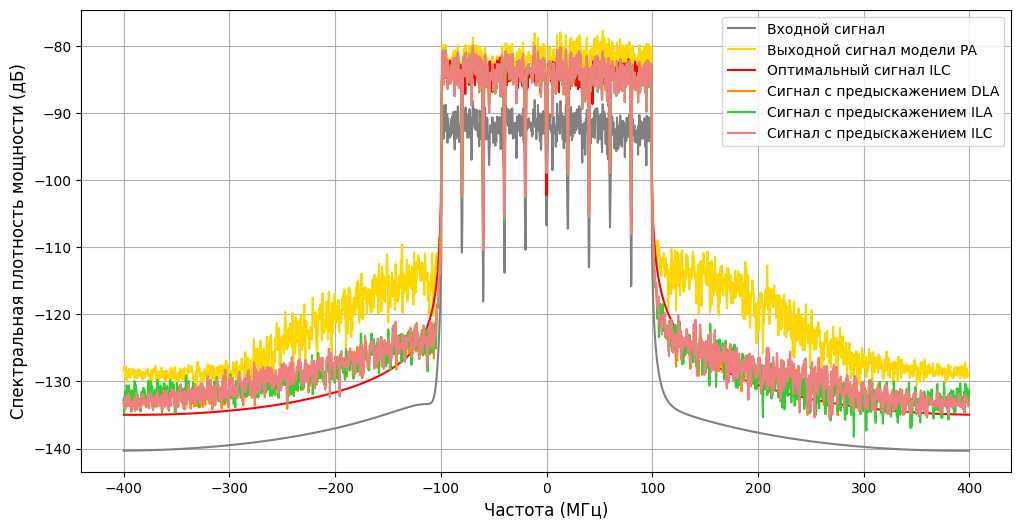

In [128]:
# построение спектра

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_x_val)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_pa)), color='gold', label='Выходной сигнал модели PA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_u_k_pa)), color='red', label='Оптимальный сигнал ILC')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_dla)), color='darkorange', label='Сигнал с предыскажением DLA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_ila)), color='limegreen', label='Сигнал с предыскажением ILA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_ilc)), color='lightcoral', label='Сигнал с предыскажением ILC')


plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()



In [129]:
# moving_average
window_size = 60

freqs_s, spectrum_x_val_s = utils.moving_average(spectrum_x_val, freqs, fs, window_size)
_, spectrum_y_val_s = utils.moving_average(spectrum_y_val, freqs, fs, window_size)
_, spectrum_y_val_gru_pa_s = utils.moving_average(spectrum_y_val_gru_pa, freqs, fs, window_size)
_, spectrum_y_val_target_s = utils.moving_average(spectrum_y_val_target, freqs, fs, window_size)

# _, spectrum_y_val_gru_dla_s = utils.moving_average(spectrum_y_val_gru_dla, freqs, fs, window_size)
# _, spectrum_y_val_gru_ila_s = utils.moving_average(spectrum_y_val_gru_ila, freqs, fs, window_size)
# _, spectrum_y_val_gru_ilc_s = utils.moving_average(spectrum_y_val_gru_ilc, freqs, fs, window_size)

_, spectrum_y_val_gru_dla_s = utils.moving_average(spectrum_y_val_gru_dla, freqs, fs, window_size)
_, spectrum_y_val_gru_ila_s = utils.moving_average(spectrum_y_val_gru_ila, freqs, fs, window_size)
_, spectrum_y_val_gru_ilc_s = utils.moving_average(spectrum_y_val_gru_ilc, freqs, fs, window_size)

_, spectrum_u_k_s = utils.moving_average(spectrum_u_k, freqs, fs, window_size)
_, spectrum_u_k_pa_s = utils.moving_average(spectrum_u_k_pa, freqs, fs, window_size)



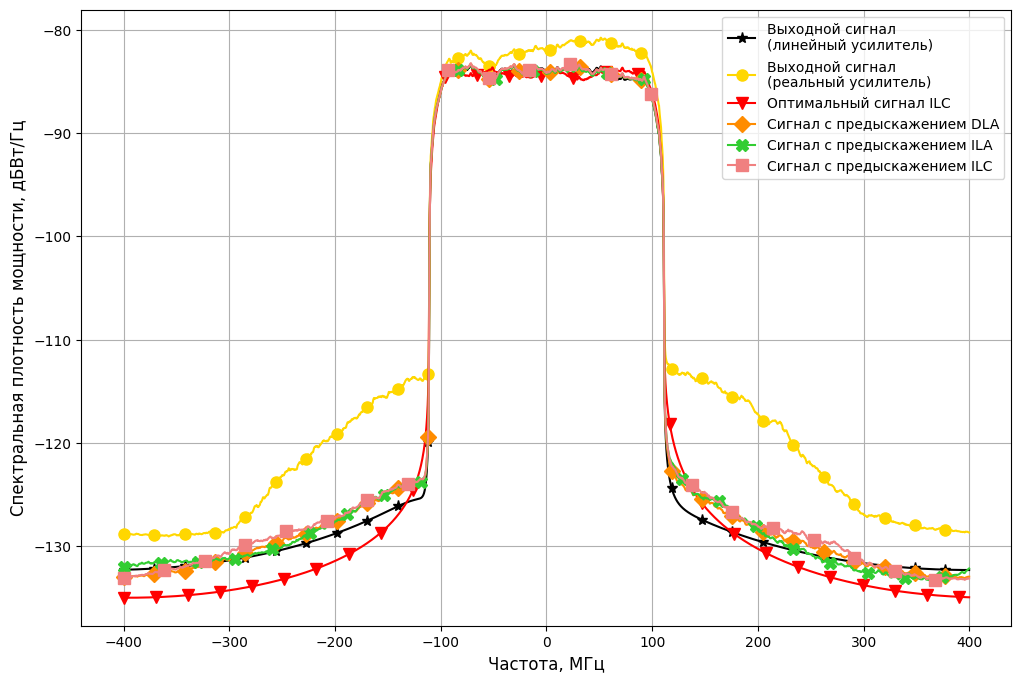

In [130]:
# (сглаженный) построение спектра

xlabel="Частота, МГц"
ylabel= "Спектральная плотность мощности, дБВт/Гц"
fontsize = 12
figsize=(12, 8)
markersize=8

plt.figure(figsize=figsize)

# plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_x_val_s)), 
#          color='grey', label='Входной сигнал',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_target_s)), 
         color='black', label='Выходной сигнал\n(линейный усилитель)',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_pa_s)), 
         color='gold', label='Выходной сигнал\n(реальный усилитель)', marker='o', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_u_k_pa_s)), 
         color='red', label='Оптимальный сигнал ILC', marker='v', markevery=95, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_dla_s)), 
         color='darkorange', label='Сигнал с предыскажением DLA', marker='D', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_ila_s)), 
         color='limegreen', label='Сигнал с предыскажением ILA', marker='X', markevery=110, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_gru_ilc_s)), 
         color='lightcoral', label='Сигнал с предыскажением ILC', marker='s', markevery=120, markersize=markersize)

plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


AM/AM & AM/PM

In [131]:
y_in_am_am, y_out_am_am = metrics.calculate_am_am(x_val, y_val)
y_in_am_pm, y_in_phase_am_pm = metrics.calculate_am_pm(x_val, y_val)

_, y_pa_am_am = metrics.calculate_am_am(x_val, y_val_gru_pa)
_, y_pa_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_gru_pa)

_, y_val_target_am_am = metrics.calculate_am_am(x_val, y_val_target)
_, y_val_target_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_target)

# x_in_am_am, u_k_am_am = metrics.calculate_am_am(x_in_tensor, u_k)
# x_in_am_pm, u_k_phase_am_pm = metrics.calculate_am_pm(x_in_tensor, u_k)

# _, u_k_pa_am_am = metrics.calculate_am_am(x_in_tensor, u_k_pa)
# _, u_k_pa_phase_am_pm = metrics.calculate_am_pm(x_in_tensor, u_k_pa)

# dpd
# _, y_val_gru_dla_am_am = metrics.calculate_am_am(x_val, y_val_gru_dla)
# _, y_val_gru_dla_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_gru_dla)

# _, y_val_gru_ila_am_am = metrics.calculate_am_am(x_val, y_val_gru_ila)
# _, y_val_gru_ila_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_gru_ila)

# _, y_val_gru_ilc_am_am = metrics.calculate_am_am(x_val, y_val_gru_ilc)
# _, y_val_gru_ilc_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_gru_ilc)

#linearized
_, y_val_gru_dla_am_am = metrics.calculate_am_am(x_val, y_val_gru_dla)
_, y_val_gru_dla_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_gru_dla)

_, y_val_gru_ila_am_am = metrics.calculate_am_am(x_val, y_val_gru_ila)
_, y_val_gru_ila_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_gru_ila)

_, y_val_gru_ilc_am_am = metrics.calculate_am_am(x_val, y_val_gru_ilc)
_, y_val_gru_ilc_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_gru_ilc)


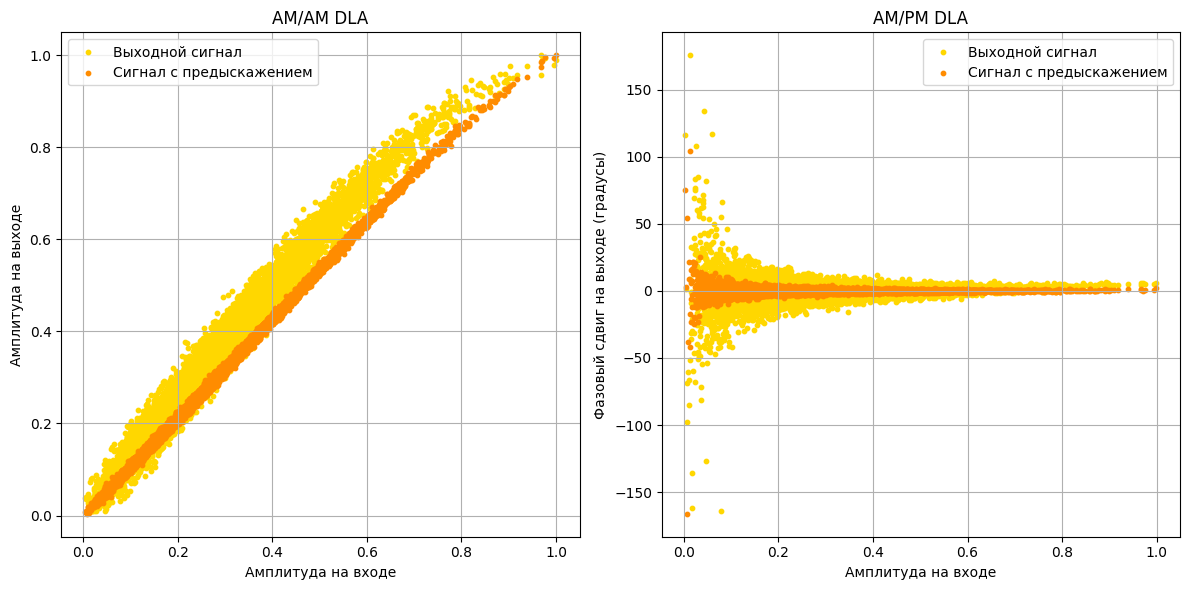

In [132]:
#DLA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_val_gru_dla_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_val_gru_dla_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_val_gru_dla_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM DLA", "AM/PM DLA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)



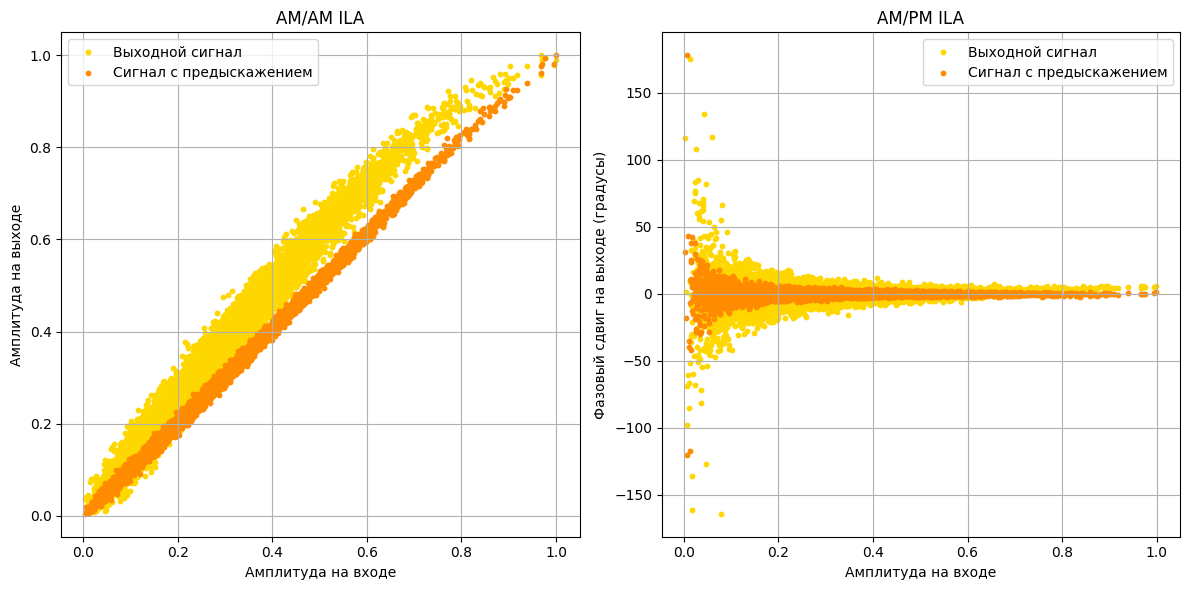

In [133]:
#ILA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_val_gru_ila_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_val_gru_ila_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_val_gru_ila_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILA", "AM/PM ILA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


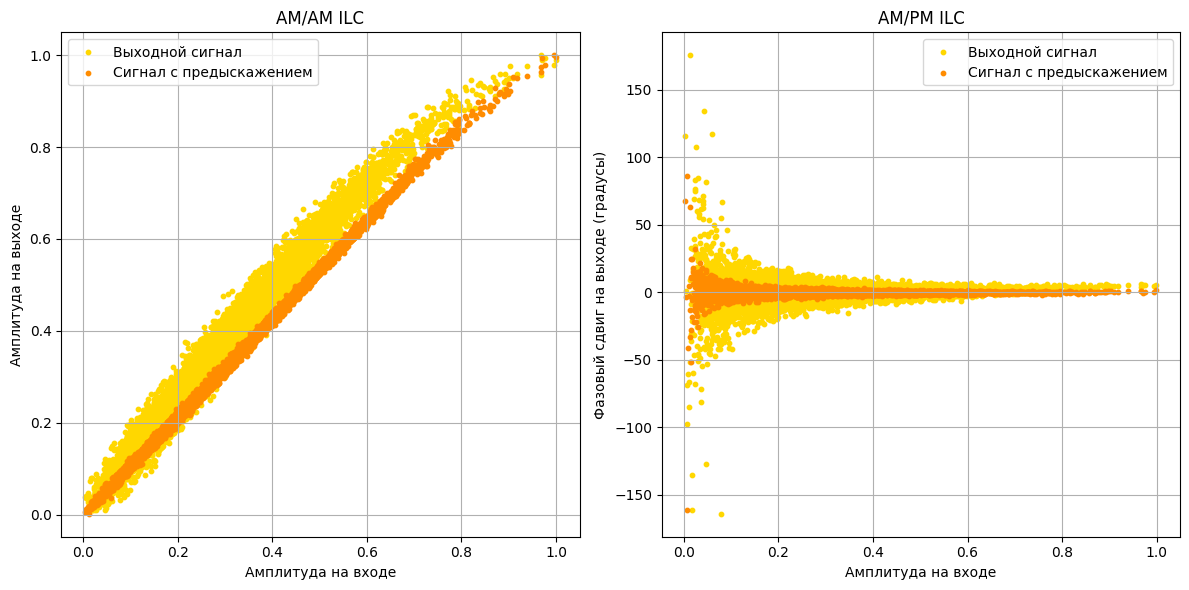

In [134]:
#ILC

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_val_gru_ilc_am_am, 'magenta', 'Сигнал на выходе корректора'),
    (y_in_am_am, y_val_gru_ilc_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_val_gru_ilc_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILC", "AM/PM ILC"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


Add noise

In [ ]:

snr_range = list(range(20, 61, 10))

epochs = 20
lr = 0.01
num_realizations = 200

hidden_size=64
num_layers=1

snr_params = params.make_snr_params(
    snr_range=snr_range,
    num_realizations=num_realizations,
    fs=fs,
    bw_main_ch=bw_sub_ch,
    epochs=epochs,
    learning_rate=lr,
    acpr_meter=acpr_meter,
    pa_model=gru_pa,
    gain=gain
)

nn_params = {
    "hidden_size": hidden_size,
    "num_layers": num_layers
}

snr_metrics_runner = pipelines.SnrPipeline(base_model=GRU, model_params=nn_params, data_dict=data, snr_params=snr_params)

In [ ]:
snr_metrics_runner.run(arch_name="DLA")

===Start training===
Epoch 00 — train_loss: 0.127464, val_loss: 0.114374, val_NMSE: -8.34
Epoch 01 — train_loss: 0.110011, val_loss: 0.113644, val_NMSE: -8.37
Epoch 02 — train_loss: 0.109522, val_loss: 0.111307, val_NMSE: -8.46
Epoch 03 — train_loss: 0.109674, val_loss: 0.110552, val_NMSE: -8.49
Epoch 04 — train_loss: 0.109560, val_loss: 0.112168, val_NMSE: -8.42
Epoch 05 — train_loss: 0.109478, val_loss: 0.110283, val_NMSE: -8.50
Epoch 06 — train_loss: 0.109579, val_loss: 0.110403, val_NMSE: -8.49
Epoch 07 — train_loss: 0.109612, val_loss: 0.112347, val_NMSE: -8.42
Epoch 08 — train_loss: 0.110094, val_loss: 0.110518, val_NMSE: -8.49
Epoch 09 — train_loss: 0.109599, val_loss: 0.110392, val_NMSE: -8.49
Epoch 10 — train_loss: 0.109484, val_loss: 0.113130, val_NMSE: -8.39
Epoch 11 — train_loss: 0.109514, val_loss: 0.111602, val_NMSE: -8.44
Epoch 12 — train_loss: 0.109879, val_loss: 0.111889, val_NMSE: -8.43
Epoch 13 — train_loss: 0.109885, val_loss: 0.112891, val_NMSE: -8.39
Epoch 14 — tr

In [ ]:
snr_metrics_runner.run(arch_name="ILA")

SNR: 20
===Start training===
Epoch 00 — train_loss: 0.020617, val_loss: 0.017704, val_NMSE: -8.41
Epoch 01 — train_loss: 0.017294, val_loss: 0.017468, val_NMSE: -8.47
Epoch 02 — train_loss: 0.017252, val_loss: 0.017355, val_NMSE: -8.50
Epoch 03 — train_loss: 0.017261, val_loss: 0.017625, val_NMSE: -8.43
Epoch 04 — train_loss: 0.017263, val_loss: 0.017616, val_NMSE: -8.43
Epoch 05 — train_loss: 0.017222, val_loss: 0.017516, val_NMSE: -8.46
Epoch 06 — train_loss: 0.017260, val_loss: 0.017429, val_NMSE: -8.48
Epoch 07 — train_loss: 0.017304, val_loss: 0.017434, val_NMSE: -8.48
Epoch 08 — train_loss: 0.017242, val_loss: 0.017434, val_NMSE: -8.48
Epoch 09 — train_loss: 0.017297, val_loss: 0.017586, val_NMSE: -8.44
Epoch 10 — train_loss: 0.017226, val_loss: 0.017950, val_NMSE: -8.35
Epoch 11 — train_loss: 0.017238, val_loss: 0.017672, val_NMSE: -8.42
Epoch 12 — train_loss: 0.017281, val_loss: 0.017306, val_NMSE: -8.51
Epoch 13 — train_loss: 0.017282, val_loss: 0.017434, val_NMSE: -8.48
Epoch

In [ ]:
snr_metrics_runner.run(arch_name="ILC")

SNR: 20
Epoch [0/200], Loss: 0.2791147828102112
Epoch [100/200], Loss: 0.14753103256225586
Время расчёта ilc_signal: 0:13:34
===Start training===
Epoch 00 — train_loss: 0.004342, val_loss: 0.042070, val_NMSE: -0.12
Epoch 01 — train_loss: 0.002563, val_loss: 0.041852, val_NMSE: -0.14
Epoch 02 — train_loss: 0.002559, val_loss: 0.041885, val_NMSE: -0.14
Epoch 03 — train_loss: 0.002558, val_loss: 0.041589, val_NMSE: -0.17
Epoch 04 — train_loss: 0.002555, val_loss: 0.041858, val_NMSE: -0.14
Epoch 05 — train_loss: 0.002557, val_loss: 0.042012, val_NMSE: -0.13
Epoch 06 — train_loss: 0.002557, val_loss: 0.041603, val_NMSE: -0.17
Epoch 07 — train_loss: 0.002552, val_loss: 0.042194, val_NMSE: -0.11
Epoch 08 — train_loss: 0.002553, val_loss: 0.041902, val_NMSE: -0.14
Epoch 09 — train_loss: 0.002554, val_loss: 0.041892, val_NMSE: -0.14
Epoch 10 — train_loss: 0.002553, val_loss: 0.041737, val_NMSE: -0.16
Epoch 11 — train_loss: 0.002553, val_loss: 0.042404, val_NMSE: -0.09
Epoch 12 — train_loss: 0.0

In [ ]:
results = snr_metrics_runner.get_results()

snr_range = results["snr_range"]

nmse_dla_list = results["dla"]["nmse"]
acpr_left_dla_list = results["dla"]["acpr_left"]
acpr_right_dla_list = results["dla"]["acpr_right"]

nmse_ila_list = results["ila"]["nmse"]
acpr_left_ila_list = results["ila"]["acpr_left"]
acpr_right_ila_list = results["ila"]["acpr_right"]

nmse_ilc_list = results["ilc"]["nmse"]
acpr_left_ilc_list = results["ilc"]["acpr_left"]
acpr_right_ilc_list = results["ilc"]["acpr_right"]

nmse_uk_list = results["uk"]["nmse"]
acpr_left_uk_list = results["uk"]["acpr_left"]
acpr_right_uk_list = results["uk"]["acpr_right"]

In [170]:
print(f"snr_range = {snr_range}")
print()

print(f"nmse_dla_list = {(nmse_dla_list)}")
print(f"acpr_left_dla_list = {acpr_left_dla_list}")
print(f"acpr_right_dla_list = {acpr_right_dla_list}")
print()

print(f"nmse_ila_list = {nmse_ila_list}")
print(f"acpr_left_ila_list = {acpr_left_ila_list}")
print(f"acpr_right_ila_list = {acpr_right_ila_list}")
print()

print(f"nmse_ilc_list = {nmse_ilc_list}")
print(f"acpr_left_ilc_list = {acpr_left_ilc_list}")
print(f"acpr_right_ilc_list = {acpr_right_ilc_list}")
print()

print(f"nmse_uk_list = {nmse_uk_list}")
print(f"acpr_left_uk_list = {acpr_left_uk_list}")
print(f"acpr_right_uk_list = {acpr_right_uk_list}")

snr_range = [20, 30, 40, 50, 60]

nmse_dla_list = [-8.42995834350586, -17.0207576751709, -26.158735275268555, -32.95079040527344, -34.03978729248047, -8.428045272827148, -16.98053550720215, -25.5406494140625, -29.953041076660156, -31.167409896850586, -8.431183815002441, -16.97576332092285, -26.164501190185547, -32.328643798828125, -34.165618896484375]
acpr_left_dla_list = [np.float64(-10.421189930703838), np.float64(-20.037879838437387), np.float64(-29.90789011393675), np.float64(-39.22647969859001), np.float64(-45.27234698383708), np.float64(-10.407254107084002), np.float64(-20.032697997400604), np.float64(-29.917782966415288), np.float64(-39.13284419016978), np.float64(-44.86941237214614), np.float64(-10.413759450274156), np.float64(-20.03587846390541), np.float64(-29.913382633178863), np.float64(-39.06628524756355), np.float64(-45.05475088232635)]
acpr_right_dla_list = [np.float64(-10.426360580414835), np.float64(-20.033489167364333), np.float64(-29.923633035271873), np.float64(-39.

In [ ]:
# # значения в виде списков чтобы не рассчитывать снова все значения

# snr_range = [20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60]

# nmse_dla_list = [-14.1044340133667, -16.018064498901367, -17.97743797302246, -19.84555435180664, -21.76476287841797, -23.601543426513672, -25.397140502929688, -27.051654815673828, -28.60270118713379, -29.951904296875, -31.10137939453125, -31.99922752380371, -32.693359375, -33.20136260986328, -33.556922912597656, -33.7752571105957, -33.94951248168945, -34.041229248046875, -34.11683654785156, -34.161094665527344, -34.18443298339844]
# acpr_left_dla_list = [-19.98307782854365, -22.044059761313314, -24.047040241882005, -25.981348959580895, -27.975370600038946, -29.942117343851447, -31.96514345661867, -33.80510011678665, -35.72137883607495, -37.63892721922215, -39.546686668811134, -41.14783435664147, -42.72300193647455, -44.1586403570728, -45.36636102368466, -46.3075550113637, -47.042928773938236, -47.62786795374185, -48.053632118082476, -48.26038054693791, -48.41887604347718]
# acpr_right_dla_list = [-20.041831052899113, -21.95478038014439, -23.98363774561688, -25.910596158467115, -27.91143197214374, -29.830851608311, -31.79363647332617, -33.5694401253062, -35.43604753655994, -37.07000947388168, -38.589720264578695, -39.981493718118756, -41.18240060456666, -42.0034433292463, -42.727465426518414, -43.28342016300996, -43.61496527628741, -43.81084719101566, -43.98201861121989, -44.08200476372817, -44.162913038570224]

# nmse_ila_list = [-13.854040145874023, -15.777467727661133, -17.762771606445312, -19.657350540161133, -21.58496856689453, -23.4307918548584, -25.17462730407715, -26.818567276000977, -28.340505599975586, -29.61135482788086, -30.697265625, -31.556087493896484, -32.22067642211914, -32.64470291137695, -32.968238830566406, -33.183040618896484, -33.31875991821289, -33.422943115234375, -33.47233963012695, -33.510684967041016, -33.5294189453125]
# acpr_left_ila_list = [-20.027768364406164, -22.02595135920506, -23.98453820660988, -25.961216816485567, -27.89464166886246, -29.93190200512903, -31.88604293318803, -33.82673998661604, -35.772038392214476, -37.61613725169961, -39.35554674161212, -40.999545012141596, -42.574679365583734, -43.93042452256015, -45.03867510014294, -45.908987401819914, -46.56702971768967, -47.03977254628908, -47.41264367177677, -47.67963051393086, -47.772995960135724]
# acpr_right_ila_list = [-19.930579122305584, -21.869039603483063, -23.92589430272745, -25.8934186825347, -27.89435768624694, -29.824054115245037, -31.657192539039386, -33.574507705349546, -35.29508665583067, -36.91289391444029, -38.35332621280914, -39.531460585547265, -40.53575407057057, -41.37233528658536, -41.93340984815785, -42.33601701225255, -42.63072372715388, -42.78626262772036, -42.906565042070014, -42.98986099019487, -43.06106380151427]

# nmse_ilc_list = [-14.0765962600708, -16.038497924804688, -17.95038604736328, -19.846113204956055, -21.75259017944336, -23.631811141967773, -25.368045806884766, -27.051647186279297, -28.601642608642578, -29.968273162841797, -31.0953426361084, -32.05195999145508, -32.759464263916016, -33.242897033691406, -33.58929443359375, -33.86418914794922, -34.00400924682617, -34.103553771972656, -34.197731018066406, -34.209129333496094, -34.251609802246094]
# acpr_left_ilc_list = [-19.987904634237463, -22.032664265763948, -23.981805945312637, -25.985078180439405, -27.97285318573928, -29.932254292413706, -31.93950622504634, -33.871982256476386, -35.687000986372624, -37.643129058194496, -39.36068479051006, -41.063457267103004, -42.61319314281078, -43.93533817262031, -45.077593707598375, -46.05866500876228, -46.68572673296391, -47.206334708000576, -47.541040851625766, -47.77248651232119, -47.95394808902196]
# acpr_right_ilc_list = [-19.970945068810845, -21.99232485637614, -23.99870022329292, -25.8777047238745, -27.85245425738548, -29.870087979042914, -31.71947716771799, -33.548264032512904, -35.38769115623252, -36.93997367595692, -38.44486643405877, -39.832029876134314, -40.894418612291034, -41.675168206028694, -42.37802985442333, -42.748574412828496, -43.07917614846056, -43.318133130296104, -43.473543736876735, -43.543050561279685, -43.59642567165372]

# nmse_uk_list = [-14.0831298828125, -16.007923126220703, -17.956777572631836, -19.8975887298584, -21.878353118896484, -23.844219207763672, -25.788644790649414, -27.7381649017334, -29.701080322265625, -31.64846420288086, -33.609657287597656, -35.53433609008789, -37.480770111083984, -39.428749084472656, -41.34610366821289, -43.275142669677734, -45.19207000732422, -47.10540771484375, -48.99323654174805, -50.86845397949219, -52.7203369140625]
# acpr_left_uk_list = [-19.998392505893012, -21.96503696465798, -23.970991167027375, -25.9149880083065, -27.92604114808463, -29.87986846158727, -31.819333935519474, -33.75500066095982, -35.68040463397734, -37.580494422986966, -39.43423352610119, -41.25160083392008, -42.91737743348149, -44.5111827081357, -45.92210941660184, -47.14031506566594, -48.14644265515601, -48.92050801676599, -49.54857485864436, -49.93755700347053, -50.273354378725]
# acpr_right_uk_list = [-19.893920065196465, -21.86624051842887, -23.84565607408318, -25.75388263544563, -27.70074723690906, -29.627564553190144, -31.569643994482238, -33.43726278691267, -35.32040951826972, -37.142184428452595, -38.9831850829623, -40.66346961805266, -42.32750364604643, -43.85724713876513, -45.296073869065694, -46.486982373361776, -47.48990958237207, -48.29148483835154, -48.9249656987649, -49.38223862798154, -49.67895177822955]

ValueError: x and y must have same first dimension, but have shapes (5,) and (15,)

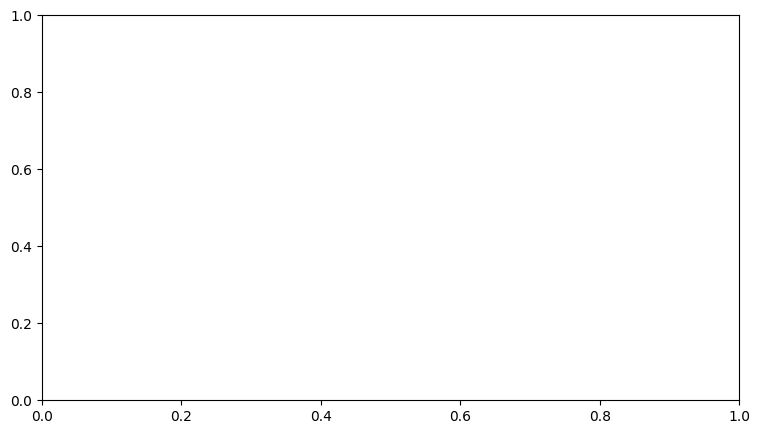

In [167]:
markersize = 8
plt.figure(figsize=(9, 5))
plt.plot(snr_range, nmse_dla_list,color='blue', linestyle='-', label="Сигнал с предыскажением DLA",
         marker='o', markersize=markersize)
plt.plot(snr_range, nmse_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA",
         marker='s', markersize=markersize)
plt.plot(snr_range, nmse_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC",
         marker='d', markersize=markersize)
plt.plot(snr_range, nmse_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC",
         marker='*', markersize=markersize)

plt.xlabel("ОСШ, дБ", fontsize=12)
plt.ylabel("NMSE, дБ", fontsize=12)
# plt.title("Зависимость NMSE от ОСШ")
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -9, 5))
plt.legend()
plt.grid(True)

plt.show()


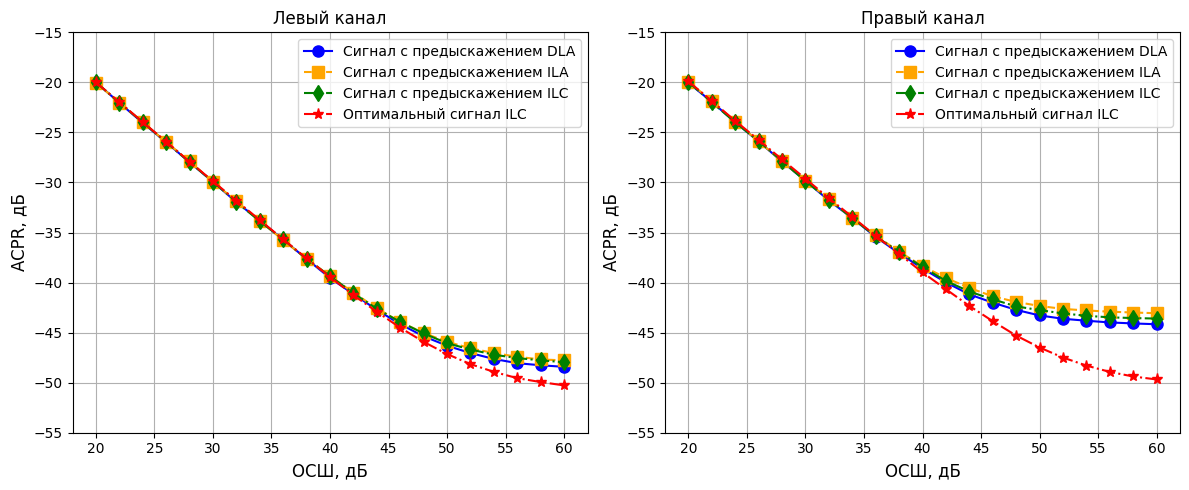

In [147]:
markersize=8
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# plt.plot(snr_range, acpr_left_dla_list, marker='o', color='blue', linestyle='-', label="Сигнал с предыскажением DLA")
# plt.plot(snr_range, acpr_left_ila_list, marker='s', color='orange', linestyle='--', label="Сигнал с предыскажением ILA")
# plt.plot(snr_range, acpr_left_ilc_list, marker='d', color='green', linestyle='-.', label="Сигнал с предыскажением ILC")
# plt.plot(snr_range, acpr_left_uk_list, marker='*', color='indigo', linestyle='-.', label="Оптимальный сигнал ILC")
plt.plot(snr_range, acpr_left_dla_list, color='blue', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, acpr_left_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, acpr_left_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, acpr_left_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Левый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, acpr_right_dla_list, color='blue', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, acpr_right_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, acpr_right_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, acpr_right_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Правый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()